# Apresentação:

O objetivo desse código é estudar sobre **Análise Discriminante**, uma classe de modelos que presspõem que os preditores tenham distribuição Gaussiana. Mais especificamente veremos a construição e implementação dos modelos de **Linear Discriminant Analisys (LDA)** e **Quadratic Discriminant Analisys (QDA)**.

## Material Base:

Em essência, o material de apoio utilizado no estudo serão **livros** e **notas de aula do Curso de Machine Learning IMPA (Instituto de Matemática Pura e Aplicada)**. Sendo eles,

* **An Introduction to Statistical Learning** - *Gareth James*, *Daniele Witten*, *Trevor Hastie*, *Robert Tibishirani* e *Jonathan Taylor* (Em essência os códigos);
* **The Elements of Statistical Learning** - *Trevor Hastie*, *Robert Tibshirani*,*Jerome Friedman*;
* **An Introduction to Generalized Linear Models** - *Annette J. Dobson*, *Adrian G. Barnett*;
* **Notas de Aula do Curso Machine Learning** - Curso de Verão IMPA.

In [4]:
# Bibliotecas de suporte:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Modelos:
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA,
                                           QuadraticDiscriminantAnalysis as QDA)

# Classes para Auxiliares aos modelos de Statistical Learning:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Classes do ISLP (Livro Tibshirani):
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, 
                         summarize, contrast)

In [5]:
# Carregrando dados:
smarket = load_data("Smarket");smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [8]:
smarket.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


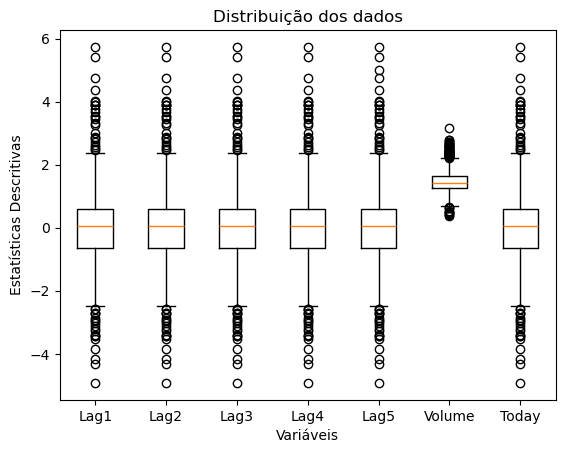

In [9]:
# Separando Colunas Numéricas:
numeric_cols = smarket.select_dtypes(include=['number']).columns
numeric_cols = [col for col in numeric_cols if col != "Year"] # Retirando Year para ajuste do Gráfico

# Criando o box plot
plt.boxplot([smarket[col] for col in numeric_cols])
plt.xticks(range(1, len(numeric_cols) + 1), numeric_cols)
plt.title("Distribuição dos dados")
plt.ylabel("Estatísticas Descritivas")
plt.xlabel("Variáveis")
plt.show()

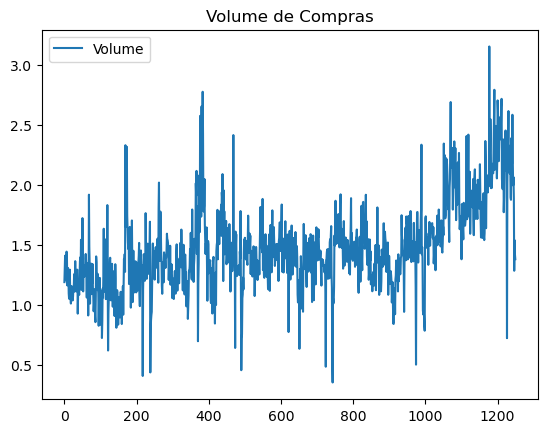

In [10]:
# Volume de Compras:
smarket.plot(y='Volume');
plt.title("Volume de Compras")
plt.show()

In [11]:
smarket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Year       1250 non-null   int64   
 1   Lag1       1250 non-null   float64 
 2   Lag2       1250 non-null   float64 
 3   Lag3       1250 non-null   float64 
 4   Lag4       1250 non-null   float64 
 5   Lag5       1250 non-null   float64 
 6   Volume     1250 non-null   float64 
 7   Today      1250 non-null   float64 
 8   Direction  1250 non-null   category
dtypes: category(1), float64(7), int64(1)
memory usage: 79.6 KB


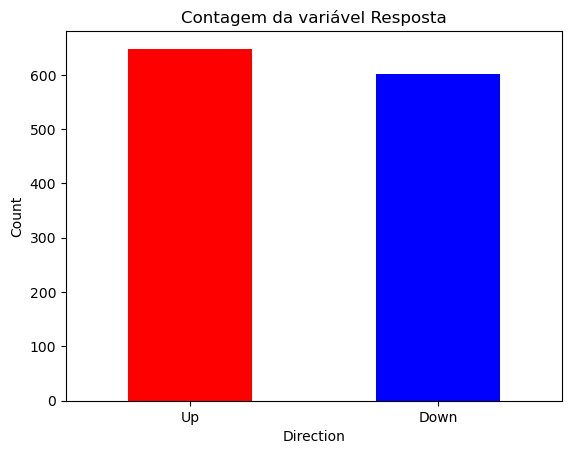

In [12]:
# Respostas:
counts = smarket["Direction"].value_counts()

# Plotando o gráfico de barras
counts.plot(kind='bar', color=["red","blue"])
plt.xlabel('Direction')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Contagem da variável Resposta')
plt.show()

# Pré processamento:

Dado que estamos lidando com um *toy dataset* não há muito o que ser feito corrigido, todavia há uma mudança fundamental que precisa ser feita. Não se faz calculos com *string* e a nosa variável alvo, resposta, está codificada como categórica, ou seja, precisamos codifica-la, transforma-la em número. Para isso, a título de estudo, aqui eu foi realizar o *One Hot Encode* com a API do sklearn e com o Pandas.

In [13]:
# Pré-processando os dados:
X = smarket.drop(['Today', 'Direction', 'Year'],axis=1)
y = smarket['Direction']

In [24]:
# Realiazando Codificação:
classes = y.unique();print(classes)
yCodificado = np.array([1 if classes[0] in classe else 0 for classe in y]);yCodificado

['Up', 'Down']
Categories (2, object): ['Down', 'Up']


array([1, 1, 0, ..., 1, 0, 0])

In [18]:
# Separando os dados:
X_train, X_test, y_train, y_test = train_test_split(X.values,yCodificado, test_size=.3, random_state=42) # Aqui, apenas o X era dataframe

# Linear Discriminant Análisys:

O **LDA** é um modelo de classificação, também baseado na **teorema de Bayes**, e que não se restringe a classificação binária. A ideia é Modela a distribuição dos preditores $X$ separadamente em cada uma das classes de resposta (ou seja, para cada valor de $Y$). Em seguida, usar o **teorema de Bayes** para inverter essas distribuições em estimativas para $Pr(Y = k|X = x)$.



In [16]:
# Instanciando Classe:
lda = LDA(store_covariance=True)

In [19]:
# Treinando o modelo
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [20]:
# Fazendo previsões
y_pred = lda.predict(X_test)

In [21]:
# Resumindo os resultados
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.20      0.30       191
           1       0.50      0.82      0.62       184

    accuracy                           0.50       375
   macro avg       0.52      0.51      0.46       375
weighted avg       0.52      0.50      0.45       375



Depois de ajustar o modelo, podemos extrair as médias nas duas classes com o atributo `means_`. Estas são as médias de cada preditor dentro de cada classe e são usadas pelo **LDA** como estimativas de $\mu_k$. Isso sugere que há uma tendência para os retornos dos 2 dias anteriores serem negativos em dias em que o mercado aumenta, e uma tendência para os retornos dos dias anteriores serem positivos em dias em que o mercado diminui.

In [22]:
lda.means_

array([[ 0.10573723,  0.08855718,  0.00616058,  0.01440876, -0.00167153,
         1.47506348],
       [-0.01740733, -0.01566379,  0.06131681,  0.01068103,  0.01043319,
         1.49017134]])

In [23]:
lda.classes_

array([0, 1])

In [26]:
lda.priors_

array([0.46971429, 0.53028571])

In [27]:
 lda.scalings_

array([[-0.62291118],
       [-0.52768125],
       [ 0.24525922],
       [-0.03892157],
       [ 0.04220654],
       [ 0.85929044]])

# LDA para Redução de Dimensionalidade:



In [31]:
# Criando o modelo LDA para redução de dimensionalidade
lda = LDA(n_components=1)  # Reduzindo para 2 dimensões

In [37]:
# Ajustando o modelo e transformando os dados de treino
X_train_lda = lda.fit_transform(X_train, y_train)

# Transformando os dados de teste
X_test_lda = lda.transform(X_test);X_test_lda[:5]

array([[ 0.19619556],
       [ 0.05961441],
       [-2.1491968 ],
       [-0.40356931],
       [-0.54893665]])